In [2]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"
CONTENT_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/reference/"

NOISY500 = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy500"
NOISY20 = "/home/yifan/dataset/noisy/pairflip/cifar10/20"
sys.path.append(REF_PATH)
sys.path.append(CONTENT_PATH)

from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


from config import config

ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
# REFERENCE
noisy_data_provider = NormalDataProvider(NOISY500,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )

clean_data_provider = NormalDataProvider(CLEAN_PATH,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1  )
clean_data = clean_data_provider.train_representation(200).squeeze()

ref_train_data = ref_provider.train_representation(200).squeeze()

# EPOCH 200
train_data = data_provider.train_representation(200).squeeze()
# EPOCH 199
# prev_train_data = data_provider.train_representation(199).squeeze()

noisy_data = noisy_data_provider.train_representation(200).squeeze()

Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [ ]:
pred_ref = ref_provider.get_pred(200, ref_train_data)

pred_train = data_provider.get_pred(200, train_data)
count = 20
for i in range(count):
    print(" ==================== sample"+ str(i) + "   ====================")
    print(pred_ref[i])
    print(pred_train[i])



In [100]:
def LMAE(Y, y, a=np.exp(1)):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 对数的底数，大于1，作用于换底公式，使所有对数函数为单调递增函数；
        该值越大，则两序列间的残差（特别是残差的离群值）对LMAE返回值影响的弱化作用越明显。
    return：
        对数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        但两序列间的残差（特别是残差的离群值）对LMAE的影响比MAE小。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使对数的真数≥1，从而使所有对数值非负，便于统一比较。
    y[y < 0] = 0
    lmae = sum(abs(np.log(abs(Y+1)) / np.log(a) - np.log(abs(y+1)) / np.log(a))) / len(Y)

    return lmae
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae


    
mesArr = []
distance_high_indicates = []
for i in range(len(pred_ref)):
    # mes_val = F.mse_loss(torch.tensor(pred_ref[i]),torch.tensor(pred_train[i]))
    mes_val = EMAE(pred_ref[i], pred_train[i])
    mesArr.append(mes_val)
    if mes_val > 20:
        distance_high_indicates.append(i)


print("total mse", EMAE(pred_ref,pred_train),len(distance_high_indicates))
# mesArr





total mse [5.424299  5.426471  6.514668  5.979216  4.905748  5.919217  4.878055
 5.1035314 4.847933  5.6697664] 40


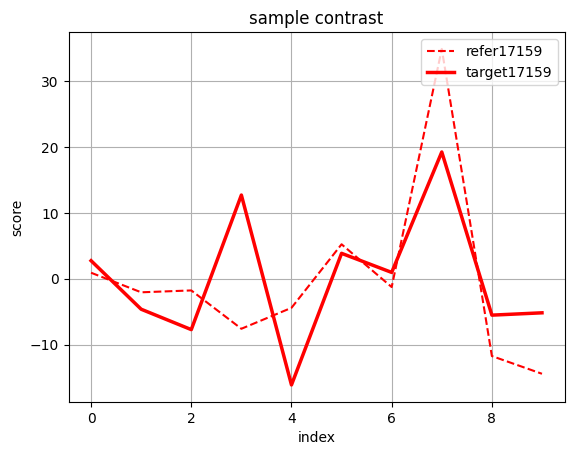

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr



plt.figure()
plt.xlabel('index')
plt.ylabel('score')
plt.title('sample contrast')
# count = 3
# for i in range(count):
# plt.plot(pred_ref[33710], 'r', lw=1.5, label='refer33710 ',linestyle="--")
# plt.plot(pred_train[33710], 'r', lw=2.5, label='target33710 ')

# plt.plot(pred_ref[49483], 'b', lw=1.5, label='refer49483',linestyle="--")
# plt.plot(pred_train[49483], 'b', lw=2.5, label='target49483')


# plt.plot(pred_ref[29673], 'g', lw=1.5, label='refer29673 ',linestyle="--")
# plt.plot(pred_train[29673], 'g', lw=2.5, label='target29673 ')

plt.plot(pred_ref[17159], 'r', lw=1.5, label='refer17159',linestyle="--")
plt.plot(pred_train[17159], 'r', lw=2.5, label='target17159')

plt.legend(loc=1)

plt.grid(True)
plt.show()